# Evaluation Code

## Initialize MatKAN model

In [1]:
from MatrixKAN import *

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=15)
np.set_printoptions(precision=15)

device = torch.device('cpu')

matkan_model = MatrixKAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


## Dataset Preparation

```math
f(x, y) = e^{\sin{\pi x} + y^2}
```

In [2]:
from kan.utils import create_dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=1000, device=device)
print(dataset['train_input'].shape, dataset['train_label'].shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


## Training

In [3]:
matkan_model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.69e-02 | test_loss: 1.62e-02 | reg: 6.32e+00 | : 100%|█| 50/50 [00:05<00:00,  8.58it

saving model version 0.1


## Run Forward Pass on the First Layer

### MatrixKAN

In [5]:
import time

# Transform data to pass the first layer only
x = dataset['test_input'][:,matkan_model.input_id.long()]

matkan_times = []

# Run forward pass of the first layer for 10000 times
with torch.no_grad():
    for _ in range(10000):
        start = time.time()
        y = matkan_model.act_fun[0].b_splines_matrix_output(x)
        end = time.time()
        matkan_times.append(end - start)

### Ours

In [ ]:
MAX_INPUT = 1000
MAX_IN_NODE = 5
MAX_OUT_NODE = 5
GRID_SIZE = 10

x = dataset['test_input'][:,matkan_model.input_id.long()]

with torch.no_grad():
    # Pre-allocate all buffers avoid recreation
    _grid_buffer = np.zeros((MAX_IN_NODE, GRID_SIZE), dtype=np.float32)
    _grid_buffer = np.ascontiguousarray(_grid_buffer)
    _coef_buffer = np.zeros((MAX_IN_NODE, MAX_OUT_NODE, 6), dtype=np.float32)
    _coef_buffer = np.ascontiguousarray(_coef_buffer)
    _X_buffer = np.zeros((MAX_INPUT, MAX_IN_NODE), dtype=np.float32)
    _X_buffer = np.ascontiguousarray(_X_buffer)

    # Pre-compute sizes
    _grid_size = MAX_IN_NODE * GRID_SIZE
    _coef_size = MAX_IN_NODE * MAX_OUT_NODE * 6
    _X_size = MAX_INPUT * MAX_IN_NODE

    # Allocated input buffer to FPGA as 1D array to send as a stream
    _input_buffer = np.zeros(_grid_size + _coef_size + _X_size, dtype=np.float32)

    # Create memory views for each segment
    _grid_view = _input_buffer[:_grid_size]
    _coef_view = _input_buffer[_grid_size : _grid_size + _coef_size]
    _X_view = _input_buffer[_grid_size + _coef_size:]

    grid = matkan_model.act_fun[0].grid
    coef = matkan_model.act_fun[0].coef

    _grid_buffer[:grid.shape[0], :grid.shape[1]] = grid.cpu().numpy().astype(np.float32)
    _coef_buffer[:coef.shape[0], :coef.shape[1], :coef.shape[2]] = coef.cpu().numpy().astype(np.float32)
    _grid_view[:] = np.ravel(_grid_buffer)
    _coef_view[:] = np.ravel(_coef_buffer)

    valid_result = np.zeros((x.shape[0], coef.shape[0], coef.shape[1]), dtype=np.float64)

    _X_buffer.fill(0)  # Reset buffer
    _X_buffer[:, :x.shape[1]] = x[:, :].cpu().numpy().astype(np.float32)
    _X_view[:] = np.ravel(_X_buffer)

    # Send to FPGA
    # Use memoryview objects for zero-copy
    mv = memoryview(_input_buffer)
    matkan_model.act_fun[0].socket.send(mv)
    fpga_output = matkan_model.act_fun[0].socket.recv()

## Plot Time Taken Distribution of MatrixKAN

For Ours, the plot should be made in the Jupyter Notebook of PYNQ board.

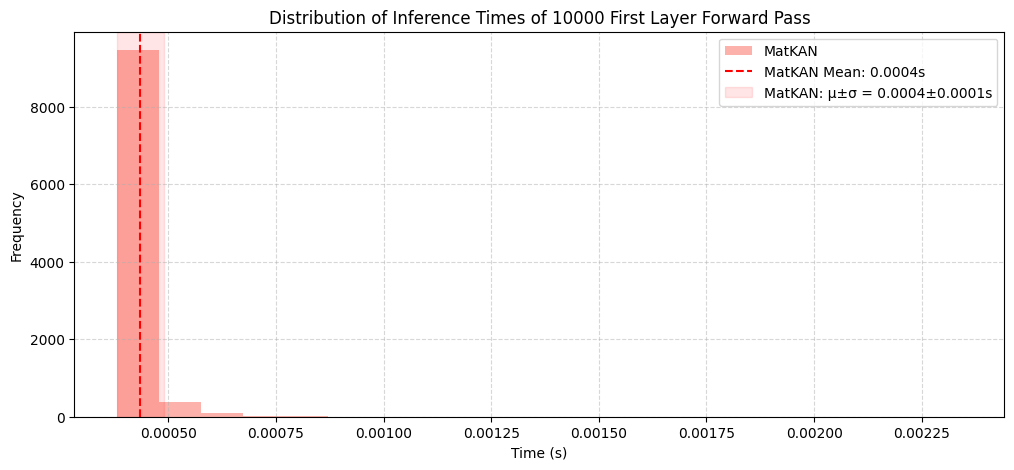

In [7]:
import matplotlib.pyplot as plt

# Calculate mean and std
mean_matkan, std_matkan = np.mean(matkan_times), np.std(matkan_times)

bin_edges = np.linspace(min(matkan_times), max(matkan_times), 21)  # 21 edges = 20 bins

plt.figure(figsize=(12, 5))
plt.hist(matkan_times, bins=bin_edges, alpha=0.6, label="MatKAN", color="salmon")
plt.axvline(mean_matkan, color='red', linestyle='--', linewidth=1.5, label=f'MatKAN Mean: {mean_matkan:.4f}s')
plt.axvspan(mean_matkan - std_matkan, mean_matkan + std_matkan, color='red', alpha=0.1, label=f'MatKAN: μ±σ = {mean_matkan:.4f}±{std_matkan:.4f}s')

plt.xlabel("Time (s)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Inference Times of 10000 First Layer Forward Pass")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

### Total Time Taken for 10000 Forward Pass

In [8]:
sum(matkan_times)

4.347366094589233